In [2]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

import DeepStrain.functions_collection as ff

In [3]:
main_path = '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_text_HF_LAX/predicts_lax'

In [70]:
patient_id = 'ID_0015'
seg_file = nb.load(os.path.join(main_path,patient_id, 'final/LAX4_seg_pred.nii.gz'))
seg_data = seg_file.get_fdata(); seg_data = np.round(seg_data).astype(np.int)
print(seg_data.shape)


(256, 256, 15)


/tmp/ipykernel_1645/2134690446.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_data = seg_file.get_fdata(); seg_data = np.round(seg_data).astype(np.int)


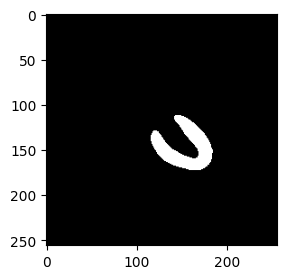

In [71]:
tf = 5
plt.figure(figsize=(3,3))
plt.imshow(seg_data[:,:,tf],cmap = 'gray')
plt.show()

In [72]:
from skimage.morphology import skeletonize
skeleton = skeletonize(seg_data[:,:,tf])
new_seg = np.copy(seg_data[:,:,tf])
new_seg[skeleton == 1] = 2

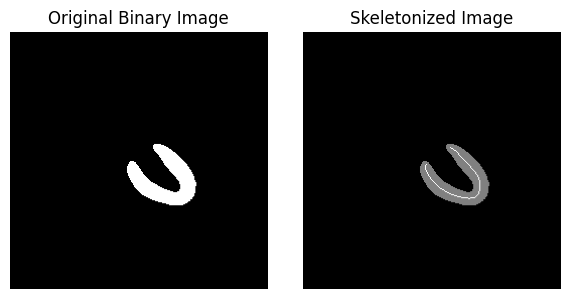

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(seg_data[:,:,tf], cmap='gray')
ax[0].set_title('Original Binary Image')
ax[0].axis('off')

ax[1].imshow(new_seg, cmap='gray')
ax[1].set_title('Skeletonized Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()

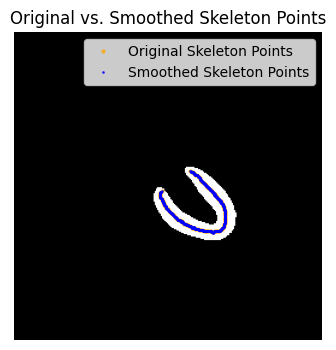

In [74]:
from scipy.spatial import distance_matrix
from scipy.interpolate import interp1d
binary_image = seg_data[:,:,tf]
y, x = np.where(skeleton == 1)

# Calculate the distance matrix for all skeleton points
coords = np.column_stack((x, y))
dist_matrix = distance_matrix(coords, coords)

# Start from the first point and find the shortest path to sort the coordinates
sorted_indices = [0]
for _ in range(1, len(x)):
    last_index = sorted_indices[-1]
    # Set distances from the already visited points to infinity to avoid revisiting
    dist_matrix[:, last_index] = np.inf
    next_index = np.argmin(dist_matrix[last_index])
    sorted_indices.append(next_index)

# Reorder x and y according to the shortest path
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Fit a cubic spline to the sorted skeleton coordinates
cubic_spline_x = interp1d(np.linspace(0, 1, len(x_sorted)), x_sorted, kind='cubic')
cubic_spline_y = interp1d(np.linspace(0, 1, len(y_sorted)), y_sorted, kind='cubic')

# Generate the smoothed coordinates
u_new = np.linspace(0, 1, 500)  # Generate 500 points for a smoother line
smooth_x = cubic_spline_x(u_new)
smooth_y = cubic_spline_y(u_new)

# Plot the original and smoothed skeleton
plt.figure(figsize=(4,4))
plt.imshow(binary_image, cmap='gray')
plt.plot(x_sorted, y_sorted, 'o', markersize=2, color='orange', label='Original Skeleton Points', alpha=0.7)
plt.plot(smooth_x, smooth_y, 'o', markersize=1, color='blue', label='Smoothed Skeleton Points', alpha=0.7)
plt.legend()
plt.title('Original vs. Smoothed Skeleton Points')
plt.axis('off')
plt.show()




In [76]:
# Calculate the distance matrix for the smoothed skeleton points
smoothed_coords = np.column_stack((smooth_x, smooth_y))
smoothed_dist_matrix = distance_matrix(smoothed_coords, smoothed_coords)

# Start from the first smoothed point and find the shortest path to sort the coordinates
sorted_smoothed_indices = [0]
for _ in range(1, len(smooth_x)):
    last_index = sorted_smoothed_indices[-1]
    # Set distances from the already visited points to infinity to avoid revisiting
    smoothed_dist_matrix[:, last_index] = np.inf
    next_index = np.argmin(smoothed_dist_matrix[last_index])
    sorted_smoothed_indices.append(next_index)

# Reorder the smooth_x and smooth_y according to the shortest path
smooth_x_sorted = smooth_x[sorted_smoothed_indices]
smooth_y_sorted = smooth_y[sorted_smoothed_indices]

# Calculate the total distance of the smoothed skeleton in mm (pixel dimension = [1,1]mm)
total_distance_mm = np.sum(np.sqrt(np.diff(smooth_x_sorted)**2 + np.diff(smooth_y_sorted)**2))

total_distance_mm

135.7783869637114

In [65]:

(tf5 - tf0) / tf0

-0.12418346000857891

In [66]:
tf5

185.73145637458873